In [117]:
import importlib
import analyzer
importlib.reload(analyzer)

from analyzer import Analyzer
import matplotlib.pyplot as plt
import numpy as np

Patient = "P013" #"P015/P015_S01_D2024-07-06"
date = "20240705"
run = "S01"
filename =   "Data/" + Patient + f"/{Patient}_{run}_D{date}.tdms"
add_filename =   "Data/" + Patient + f"/{Patient}_{run}_D{date}_addCh.tdms"
log_file_path  = "Data/" + Patient + "/QZFM_log_file.txt"
sensor_channels_to_excllude = {"Brustlage": ["OY_x", "EY_y", "YP_z", "NL_z", "EY_x", "NL_y", "F2_y", "EZ_y"]}
analysis = Analyzer(filename, add_filename, log_file_path, sensor_channels_to_exclude=sensor_channels_to_excllude) # {"Brustlage": ["NL_x", "C1_x", "C1_y"], "Rueckenlage": ["NL_x", "C1_x", "C1_y"]}

key = "Brustlage" # "Brustlage" # "Rueckenlage" # "Bauchlage" # "Brust" # "Ruecken"

intervall_start = 1000
intervall_end = 5000

2025-04-30 21:08:43,332 - INFO - Using device: cpu
2025-04-30 21:08:44,250 - INFO - Loaded primary TDMS file: Data/P013/P013_S01_D20240705.tdms
2025-04-30 21:08:44,700 - INFO - Loaded additional TDMS file: Data/P013/P013_S01_D20240705_addCh.tdms
2025-04-30 21:08:44,702 - INFO - Loaded sensor log file: Data/P013/QZFM_log_file.txt
2025-04-30 21:08:44,702 - INFO - Available runs: Brustlage, Rueckenlage, Empty, Empty_withFZ
2025-04-30 21:08:44,720 - INFO - Model loaded from MCG_segmentation/MCGSegmentator_s/checkpoints/best/model.pth


# Testing model segmentation

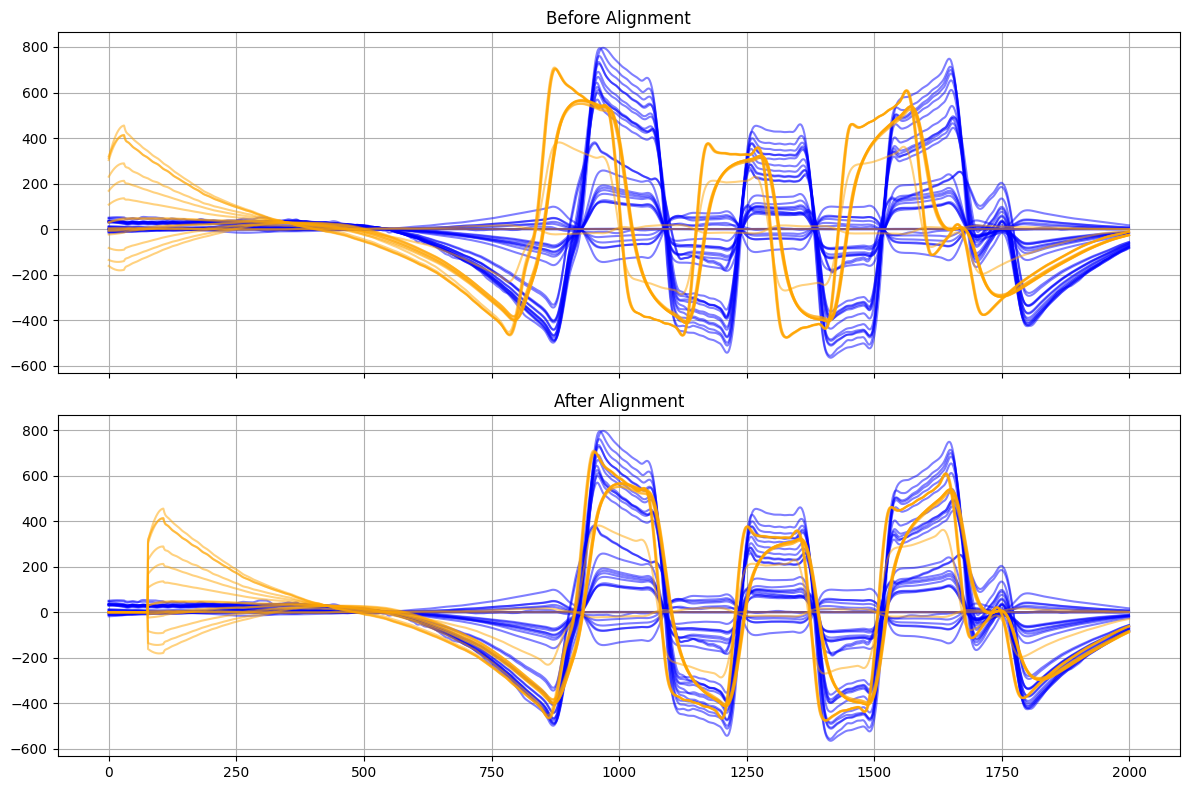

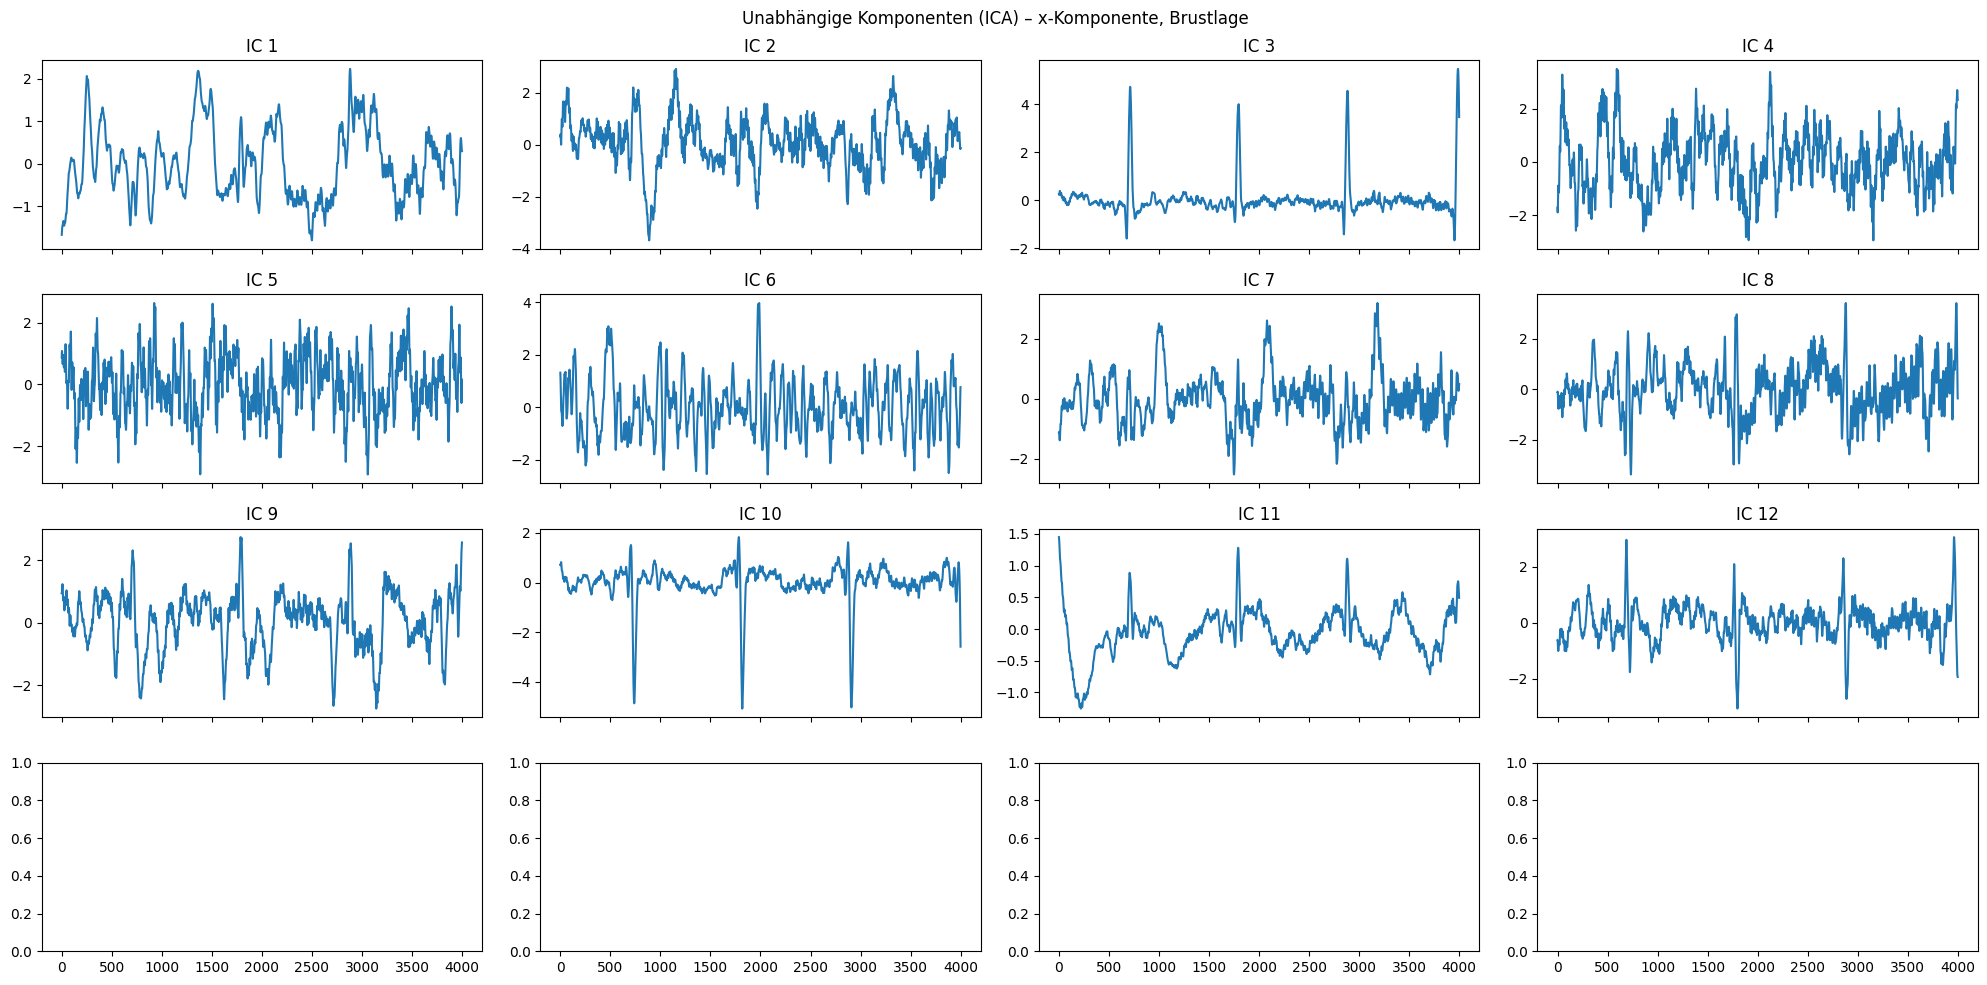

/Users/samuelfriese/Desktop/Projekte/Bachelorarbeit/analyzer.py:664: UserWarning: Resampled length 1000 is less than window size 2000. Adjusting window size to 1000.
  warnings.warn(f"Resampled length {num_samples_target} is less than window size {window_size}. "
/Users/samuelfriese/Desktop/Projekte/Bachelorarbeit/analyzer.py:664: UserWarning: Resampled length 500 is less than window size 2000. Adjusting window size to 500.
  warnings.warn(f"Resampled length {num_samples_target} is less than window size {window_size}. "



Channel Selection Results:
Channel   Mean Conf   P-Wave %    QRS %       T-Wave %    Plausibility   Final Score 
-------------------------------------------------------------------------------------
1         0.8060      24.60       27.80       47.60       0.2000         0.7753      
2         0.8424      17.60       4.40        51.80       0.2632         0.8212      
3         0.8722      14.80       11.40       11.80       0.7576         0.9472      
4         0.7996      0.00        12.60       39.80       0.3597         0.8014      
5         0.8222      0.00        65.80       9.60        0.1348         0.7771      
6         0.7744      0.00        30.60       31.40       0.2857         0.7636      
7         0.7951      0.00        8.60        40.80       0.3472         0.7948      
8         0.8462      13.00       47.40       14.20       0.2315         0.8183      
9         0.8227      17.80       22.40       31.00       0.4717         0.8449      
10        0.8769      17.4

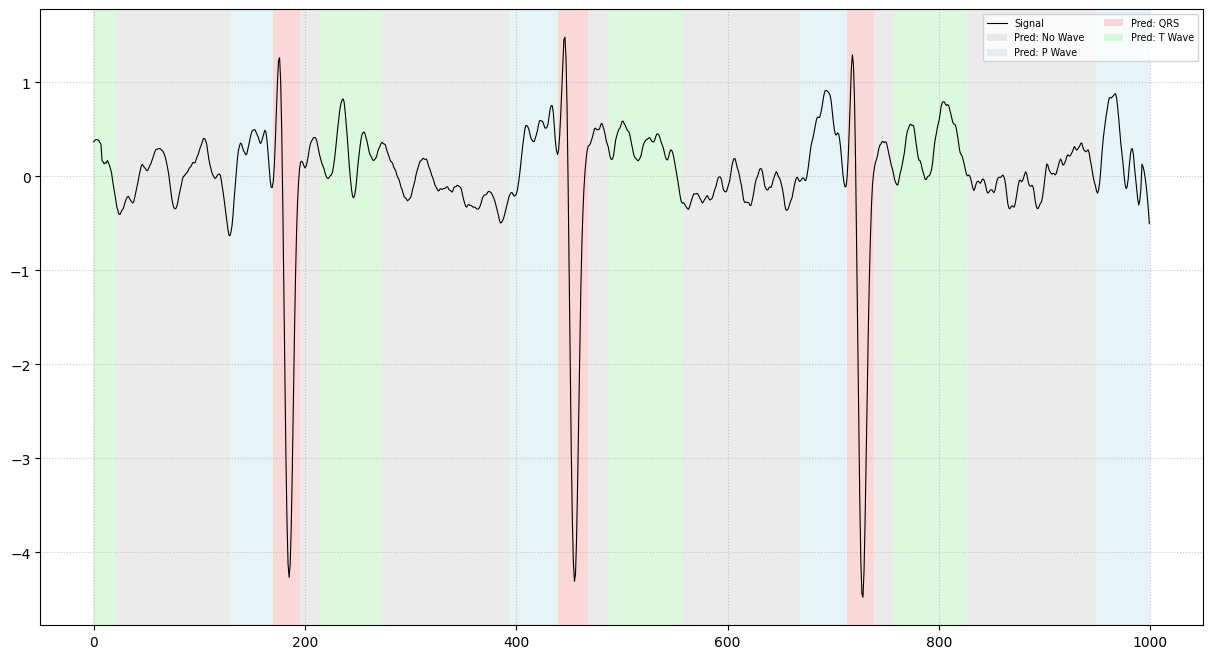

In [118]:

(x_data, y_data, z_data), time, single_run = analysis.prepare_data(key, apply_default_filter=True, plot_alignment=True)


S_ica = analysis.apply_ICA(y_data)

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20,10), sharex=True)
for i, ax in enumerate(axes.flat):
    if i >= len(S_ica):
        break
    ax.plot(S_ica[i][1000:5000])
    ax.set_title(f"IC {i+1}")
plt.suptitle(f"Unabhängige Komponenten (ICA) – x-Komponente, {key}")
plt.tight_layout()
plt.show()



labels, data, confidence = analysis.segment_entire_run(S_ica[:, 1000:5000])

argmax, _ = analysis.find_cleanest_channel(S_ica[:, 1000:3000])


analysis.plot_segmented_signal(data[argmax, :], labels[argmax, :])

Improve Windowing

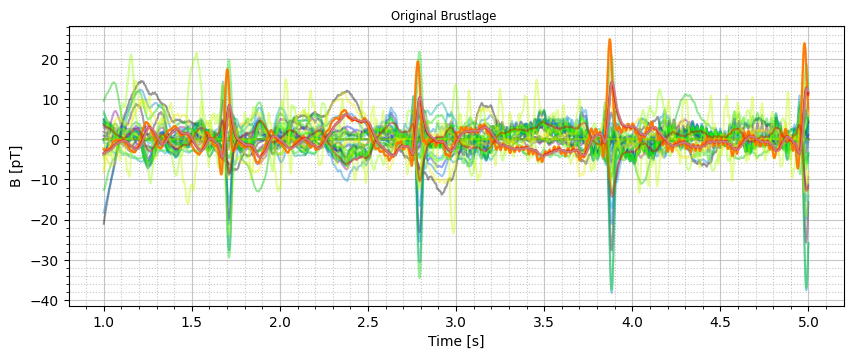

Average Heart Rate: 58.73 +/- 9.81 bpm
Average Heart Rate Variability (SDNN): 95.76 +/- 135.19 ms


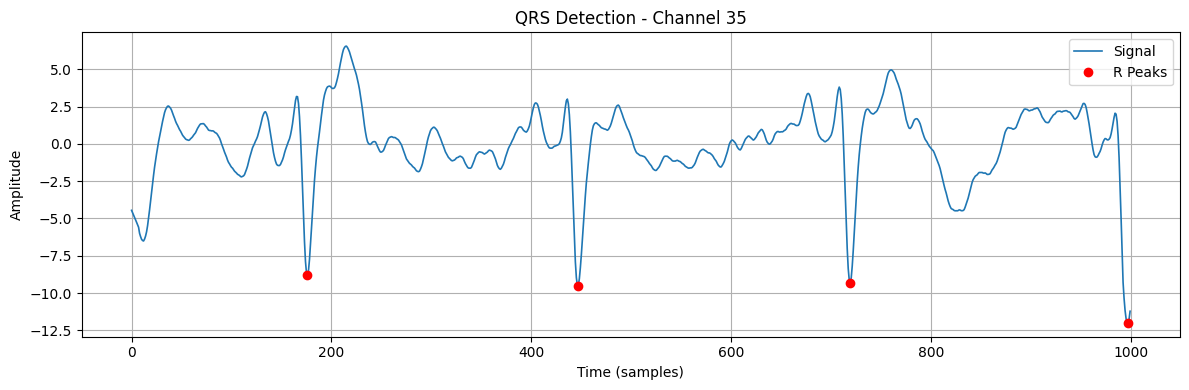

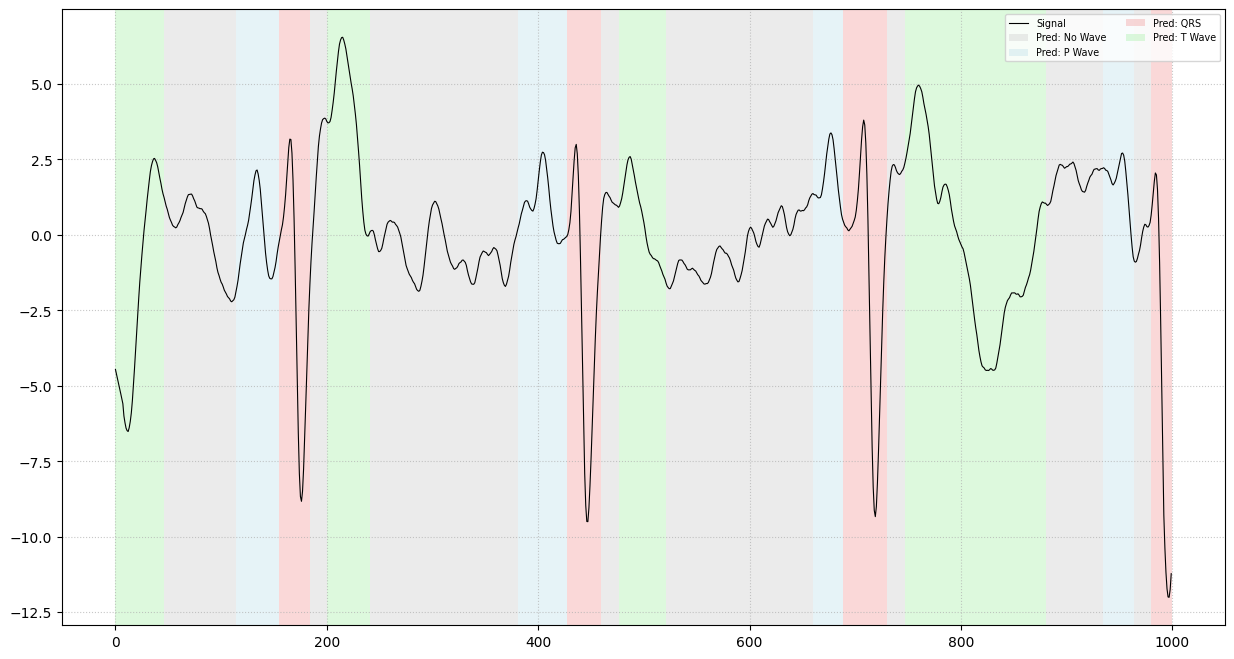

(48, 1000)


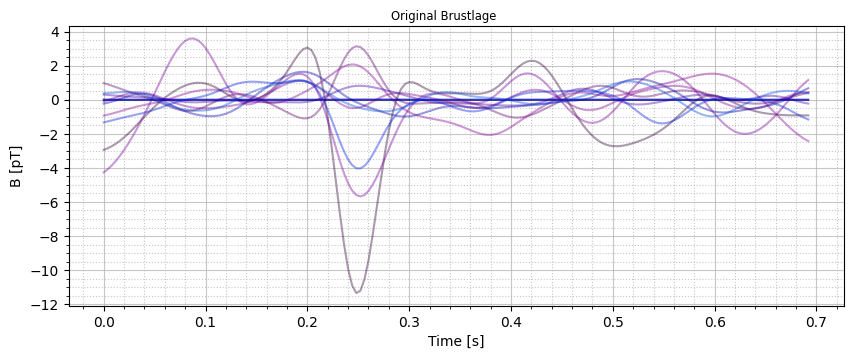

Heart Rate: 55.35 bpm
Heart Rate Variability (SDNN): 4.00 ms
Number of detected peaks: 3
Number of plausible RR intervals used: 2


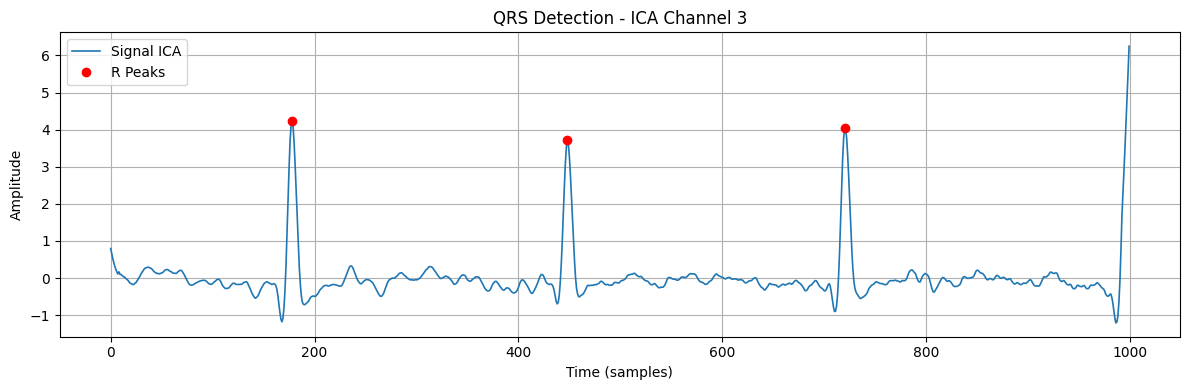

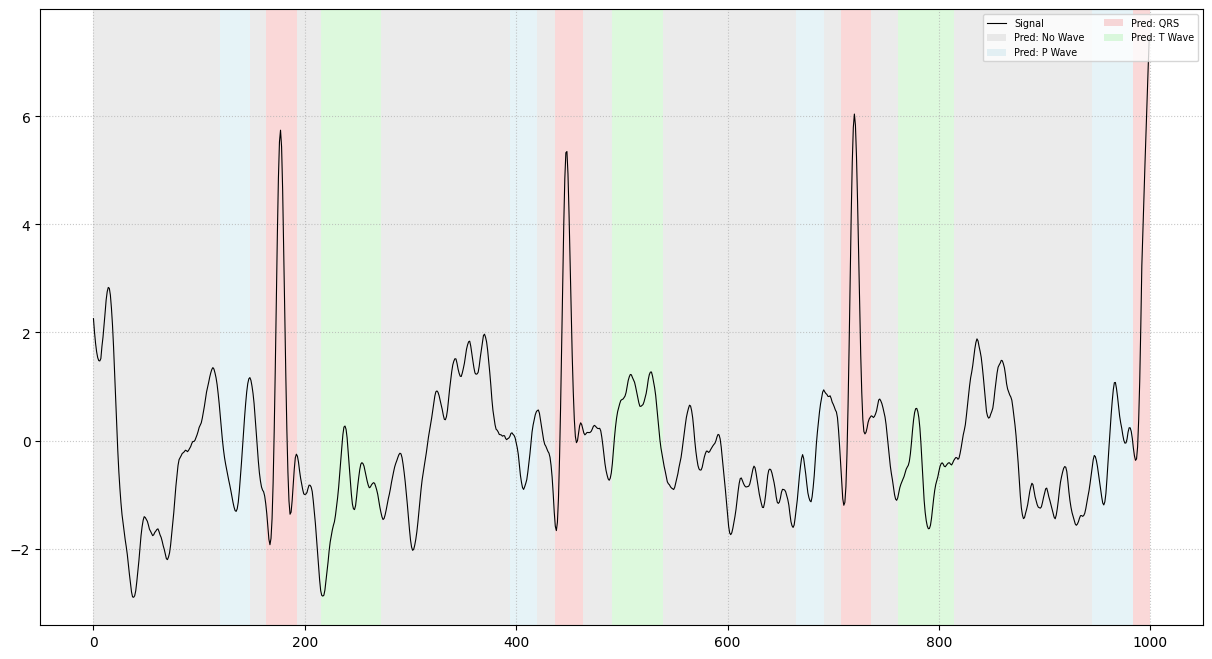

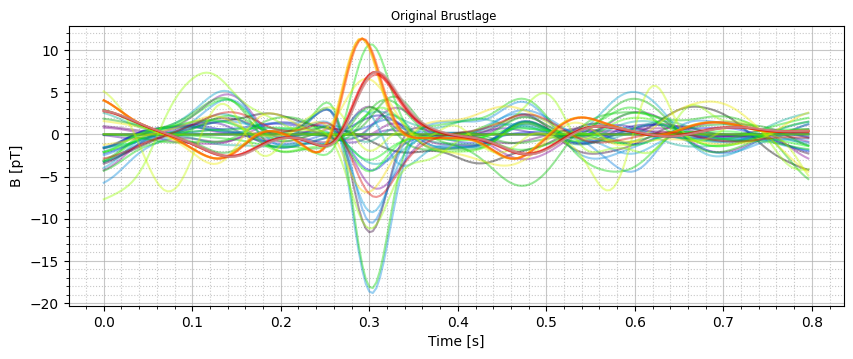

Heart Rate: 54.81 bpm
Heart Rate Variability (SDNN): 12.36 ms
Number of detected peaks: 4
Number of plausible RR intervals used: 3


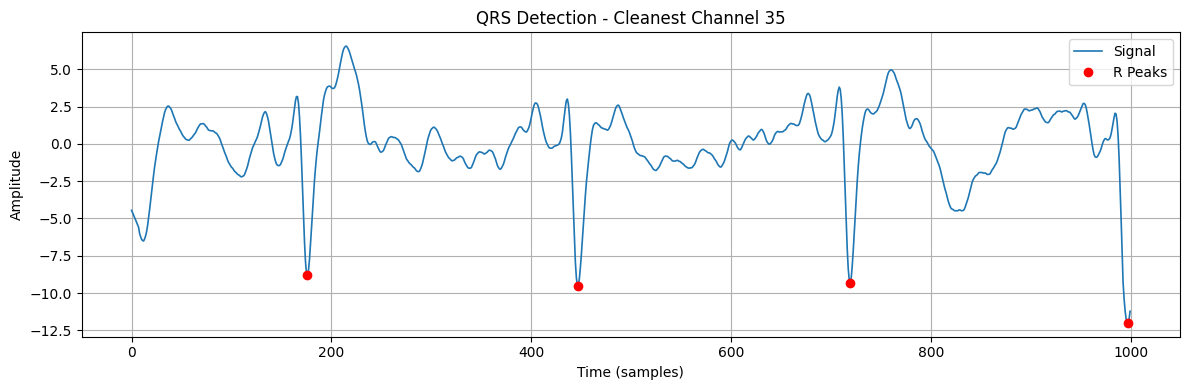

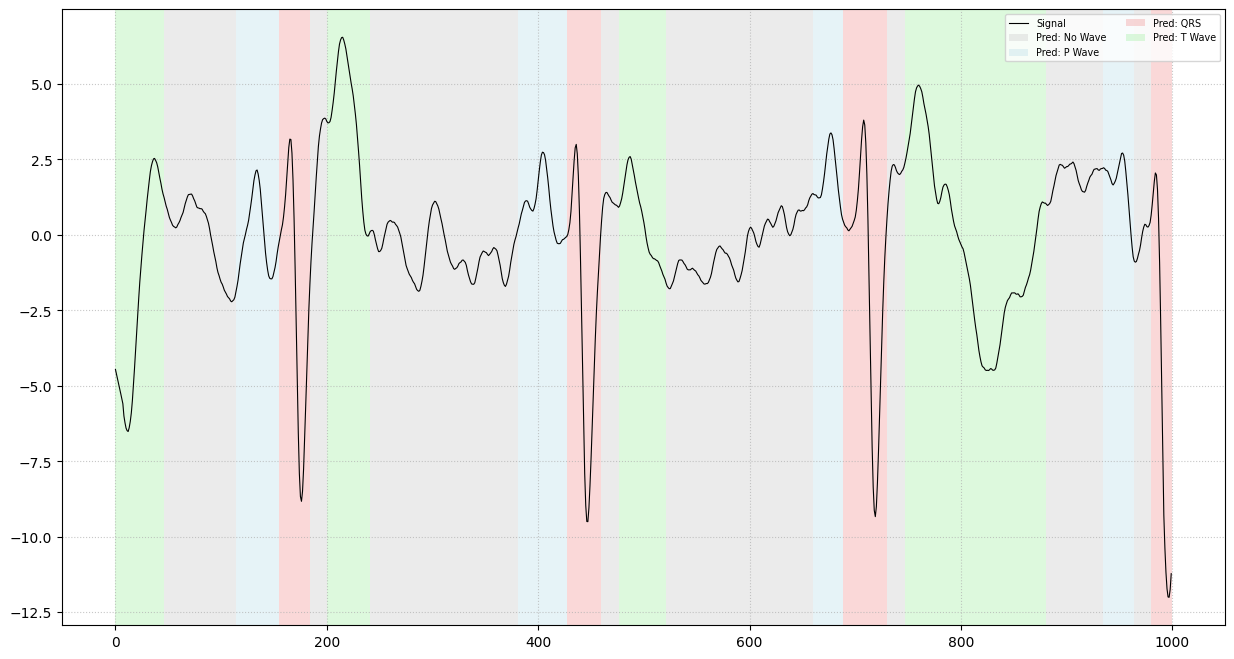

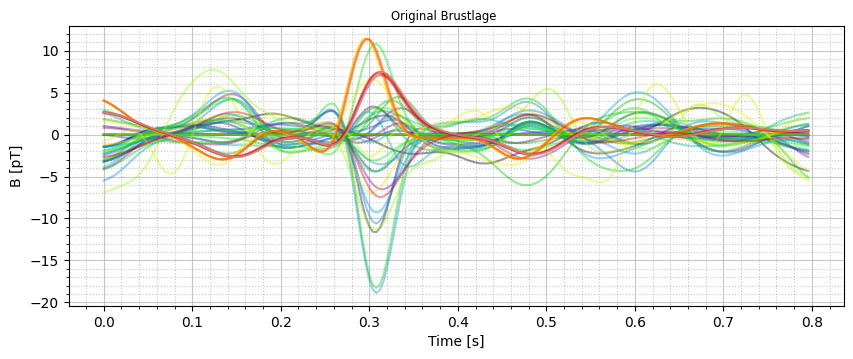

In [119]:

_data = single_run[:, intervall_start:intervall_end]

analysis.plotting_time_series(_data, time[intervall_start:intervall_end], 48, f"Original {key}")


# multichannel Peak detection
peak_positions, resampled_data, ch, labels, _, _ = analysis.detect_qrs_complex_peaks_all_channels(_data, print_heart_rate=True, confidence_threshold=0.7)

# Check if peak_positions are valid
if peak_positions[ch] is not None and len(peak_positions[ch]) > 0:
    plt.figure(figsize=(12, 4))
    plt.plot(resampled_data[ch, :], label='Signal', linewidth=1.2)
    plt.plot(peak_positions[ch], resampled_data[ch, peak_positions[ch]], "ro", markersize=6, label='R Peaks')
    plt.title(f"QRS Detection - Channel {ch + 1}")
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("No R peaks detected or `peak_positions` is empty.")

analysis.plot_segmented_signal(resampled_data[ch, :], labels[ch, :])

# window averaging
print(resampled_data.shape)

avg_channels, time_window = analysis.avg_window(resampled_data, peak_positions, window_left=0.25, window_right=0.45, heart_beat_score_threshold=0.5)
analysis.plotting_time_series(avg_channels, time_window, 12, f"Original {key}")




# use channel out of SICA for peak detection
peak_positions, resampled_data_, ch, labels, _, _ = analysis.detect_qrs_complex_peaks_cleanest_channel(S_ica[:, intervall_start:intervall_end], print_heart_rate=True, confidence_threshold=0.7)



if peak_positions is not None and len(peak_positions) > 0:
    plt.figure(figsize=(12, 4))
    plt.plot(resampled_data_[ch, :], label='Signal ICA', linewidth=1.2)
    #plt.plot(resampled_data[ch, :], label='Signal', linewidth=1.2)
    plt.plot(peak_positions, resampled_data_[ch, peak_positions], "ro", markersize=6, label='R Peaks')
    plt.title(f"QRS Detection - ICA Channel {ch + 1}")
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("No R peaks detected or `peak_positions` is empty.")

analysis.plot_segmented_signal(resampled_data[ch, :], labels[ch, :])
# window averaging
avg_channels, time_window = analysis.avg_window(resampled_data, peak_positions, window_left=0.3, window_right=0.5)
analysis.plotting_time_series(avg_channels, time_window, 48, f"Original {key}")



# use cleanest channel for peak detection
peak_positions, resampled_data_, ch, labels, _, _ = analysis.detect_qrs_complex_peaks_cleanest_channel(single_run[:, intervall_start:intervall_end], print_heart_rate=True, confidence_threshold=0.7)
if peak_positions is not None and len(peak_positions) > 0:
    plt.figure(figsize=(12, 4))
    plt.plot(resampled_data[ch, :], label='Signal', linewidth=1.2)
    #plt.plot(resampled_data[ch, :], label='Signal', linewidth=1.2)
    plt.plot(peak_positions, resampled_data[ch, peak_positions], "ro", markersize=6, label='R Peaks')
    plt.title(f"QRS Detection - Cleanest Channel {ch + 1}")
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("No R peaks detected or `peak_positions` is empty.")
analysis.plot_segmented_signal(resampled_data[ch, :], labels[ch, :])

# window averaging
avg_channels, time_window = analysis.avg_window(resampled_data, peak_positions, window_left=0.3, window_right=0.5)
analysis.plotting_time_series(avg_channels, time_window, 48, f"Original {key}")



## Test Magnetic Moment fit

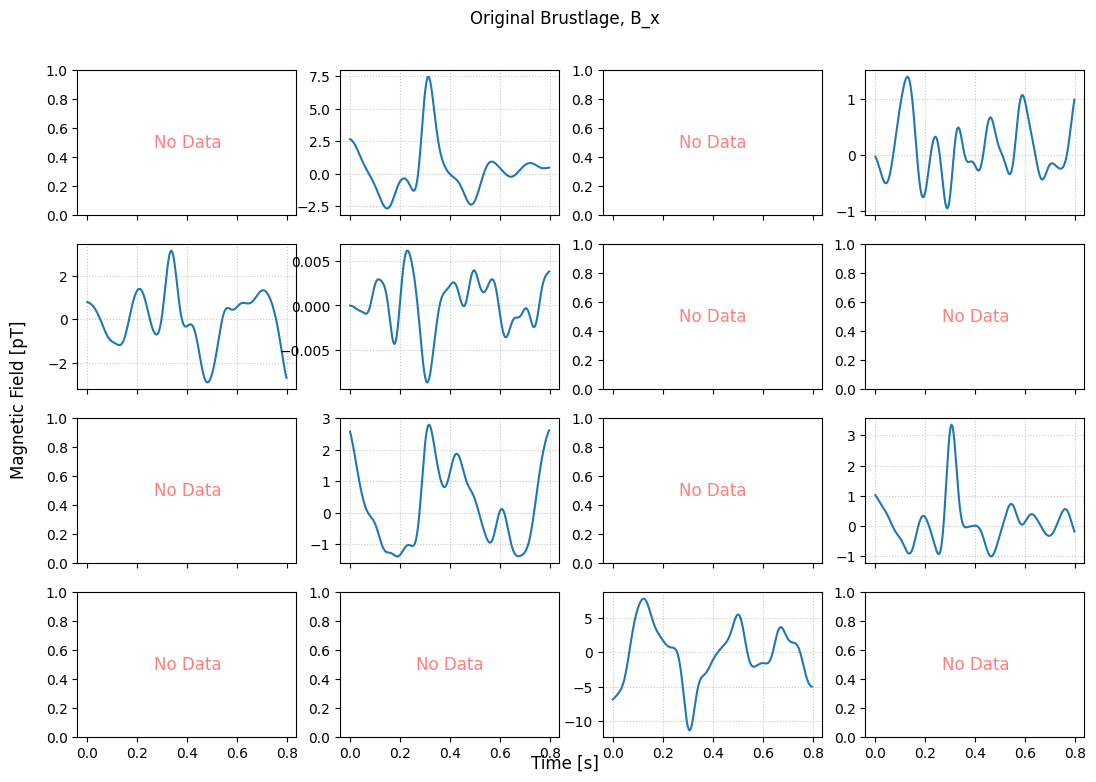

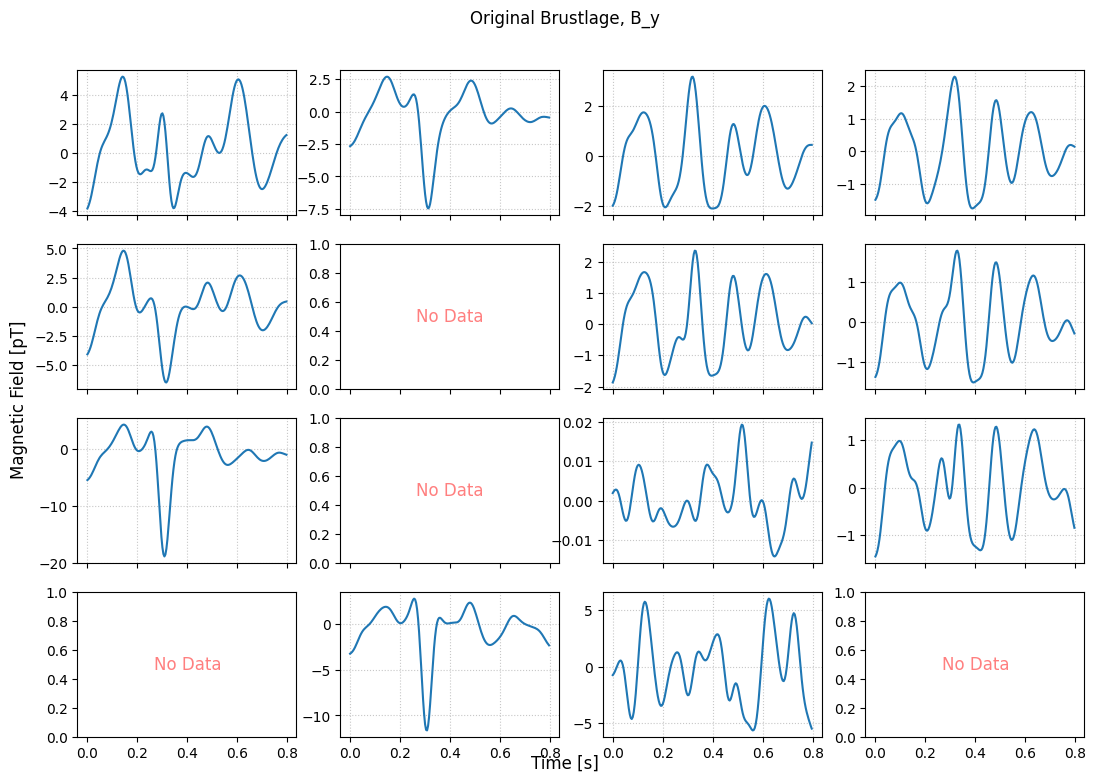

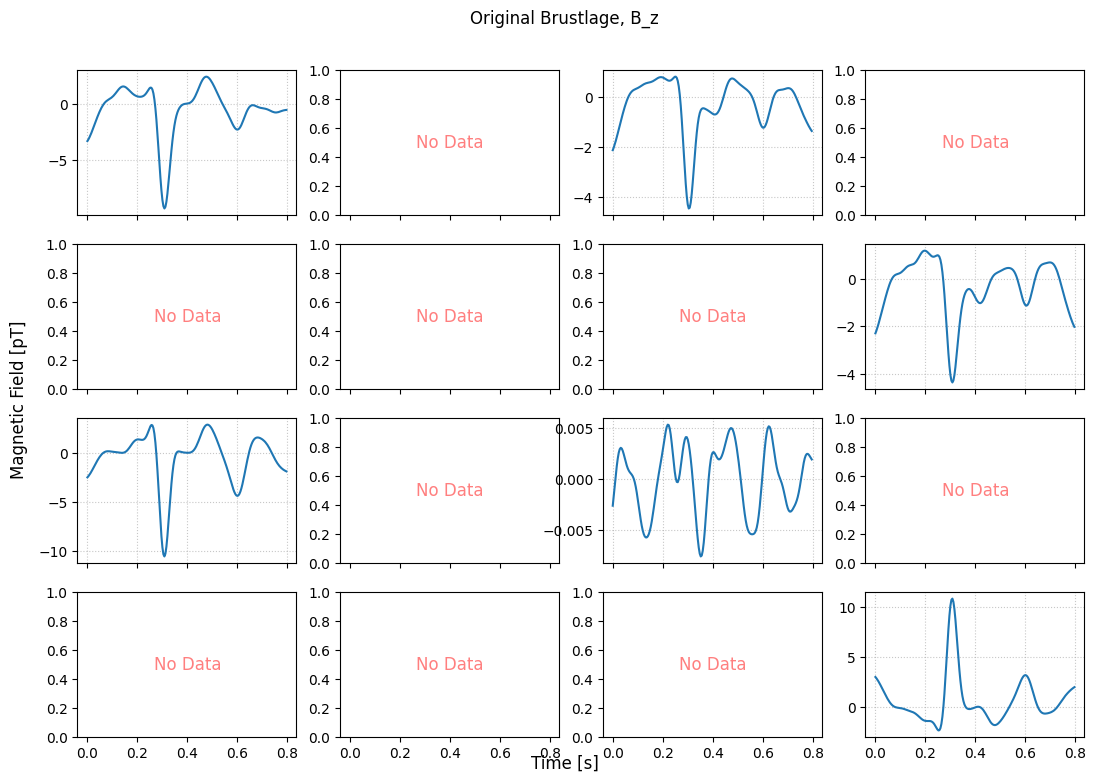

(4, 4, 200) (4, 4, 200) (4, 4, 200)
Fitted time 0/200
Fitted time 100/200


In [120]:
import numpy as np
import torch
import matplotlib.pyplot as plt

from scipy.ndimage import gaussian_filter1d

def gaussian_smoothing(x, sigma=2):
    """Gaussian smoothing along time axis."""
    x_smooth = gaussian_filter1d(x, sigma=sigma, axis=-1, mode='nearest')
    return x_smooth


# --- Load data ---
x_data, y_data, z_data = analysis.get_field_directions(avg_channels, key)

analysis.plot4x4(x_data, time_window, f"Original {key}, B_x")
analysis.plot4x4(y_data, time_window, f"Original {key}, B_y")
analysis.plot4x4(z_data, time_window, f"Original {key}, B_z")

print(x_data.shape, y_data.shape, z_data.shape)

# --- Constants and grid ---
grid_spacing = 25.3e-3  # 25.3 mm
MU_0 = 4 * np.pi * 1e-7  # T·m/A

x = np.arange(4) * grid_spacing
y = np.arange(4) * grid_spacing
X, Y = np.meshgrid(x, y)
sensor_positions_np = np.stack([X, Y, np.zeros_like(X)], axis=-1)  # (4,4,3)

# Torch version
sensor_positions = torch.tensor(sensor_positions_np, dtype=torch.float32)

# --- Functions ---
def dipole_field_torch(r_sensor, r0, m):
    r_prime = r_sensor - r0
    r_norm = torch.norm(r_prime, dim=-1, keepdim=True)
    r_hat = r_prime / r_norm
    B = (MU_0 / (4 * np.pi)) * ( (3 * r_hat * torch.sum(r_hat * m, dim=-1, keepdim=True) - m) / (r_norm**3) )
    return B

def fit_dipole_single_time(sensor_positions, B_meas_t, lr=1e-1, n_steps=500):
    sensors_flat = sensor_positions.view(-1, 3)
    B_meas_flat = torch.tensor(B_meas_t.reshape(-1, 3), dtype=torch.float32)

    valid = torch.norm(B_meas_flat, dim=-1) > 0  # Only keep sensors with nonzero signal
    if torch.sum(valid) == 0:
        print("Warning: No valid sensors at this timestep.")
        return np.zeros(3), np.zeros(3)

    sensors_valid = sensors_flat[valid]
    B_meas_valid = B_meas_flat[valid]

    r0 = torch.nn.Parameter(torch.tensor([0.05, 0.05, 0.05], dtype=torch.float32))  # Start near center
    m = torch.nn.Parameter(torch.randn(3) * 1e-12)  # Small random dipole

    optimizer = torch.optim.Adam([r0, m], lr=lr)

    for step in range(n_steps):
        optimizer.zero_grad()
        B_pred = dipole_field_torch(sensors_valid, r0, m)
        loss = torch.mean((B_pred - B_meas_valid)**2)
        loss.backward()
        optimizer.step()

        # Clip r0 to stay in grid
        r0.data = torch.clamp(r0.data, 0.0, 4*grid_spacing)

    return r0.detach().numpy(), m.detach().numpy()

def fit_dipole_over_time(sensor_positions, B_meas):
    T = B_meas.shape[-1]
    r0_all = np.zeros((T, 3))
    m_all = np.zeros((T, 3))

    for t in range(T):
        B_meas_t = B_meas[..., t]
        r0, m = fit_dipole_single_time(sensor_positions, B_meas_t)

        r0_all[t] = r0
        m_all[t] = m

        if t % 100 == 0:
            print(f"Fitted time {t}/{T}")

    return r0_all, m_all

def predict_sensor_signal(sensor_indices, r0_all, m_all, sensor_positions_np, T):
    sensor_positions = torch.tensor(sensor_positions_np, dtype=torch.float32)
    predicted_signals = {}

    for (i, j) in sensor_indices:
        r_sensor = sensor_positions[i, j]
        signal = np.zeros((3, T))

        for t in range(T):
            r0 = torch.tensor(r0_all[t], dtype=torch.float32)
            m = torch.tensor(m_all[t], dtype=torch.float32)
            B = dipole_field_torch(r_sensor.unsqueeze(0), r0, m)
            signal[:, t] = B[0].detach().numpy()

        predicted_signals[(i, j)] = signal

    return predicted_signals

# --- Prepare field data ---
Bx_meas = x_data * 1e-12
By_meas = y_data * 1e-12
Bz_meas = z_data * 1e-12

B_meas = np.zeros((4, 4, 3, Bx_meas.shape[-1]))
B_meas[..., 0, :] = Bx_meas
B_meas[..., 1, :] = By_meas
B_meas[..., 2, :] = Bz_meas

T = Bx_meas.shape[-1]

B_meas_smooth = gaussian_smoothing(B_meas, sigma=2)

# --- Fit ---
r0_all, m_all = fit_dipole_over_time(sensor_positions, B_meas_smooth)



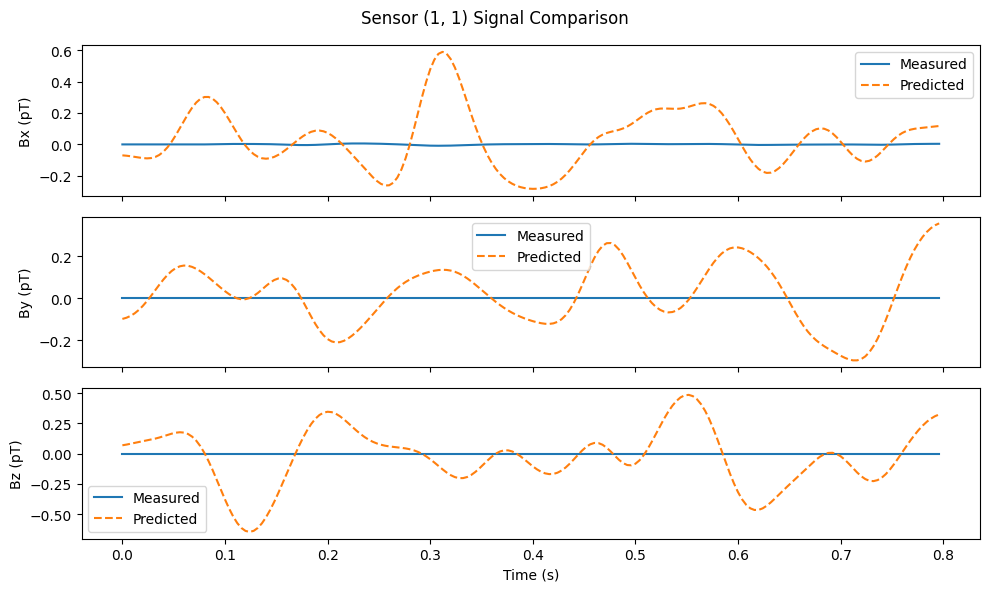

In [121]:
# --- Predict fields at selected sensors ---
sensor_indices = [(1,1), (2,2), (3,1)]
predicted = predict_sensor_signal(sensor_indices, r0_all, m_all, sensor_positions_np, T)

# --- Plotting ---
sensor = (1,1)
pred = predicted[sensor]  # (3,T)

# Measured signal at (1,1)
measured = np.stack([Bx_meas[sensor], By_meas[sensor], Bz_meas[sensor]], axis=0)

time = np.arange(T) / 250  # Sampling rate 250Hz

fig, axs = plt.subplots(3, 1, figsize=(10, 6), sharex=True)
components = ['Bx', 'By', 'Bz']

for i in range(3):
    axs[i].plot(time, measured[i]*1e12, label='Measured')  # back to pT
    axs[i].plot(time, pred[i]*1e12, label='Predicted', linestyle='--')
    axs[i].set_ylabel(f'{components[i]} (pT)')
    axs[i].legend()

axs[-1].set_xlabel('Time (s)')
plt.suptitle(f'Sensor {sensor} Signal Comparison')
plt.tight_layout()
plt.show()

## Magentic Heart Vector

f1_data shape: (3, 200)

Channel Selection Results:
Channel   Mean Conf   P-Wave %    QRS %       T-Wave %    Plausibility   Final Score 
-------------------------------------------------------------------------------------
1         0.8241      28.50       14.50       29.50       0.4255         0.6098      
2         0.8277      0.00        51.50       23.00       0.1835         0.4661      
3         0.9301      0.00        0.00        0.00        0.2439         0.0000      

Best Channel Summary:
Channel   : 1
Mean Conf : 0.8241
Plausibility: 0.4255
Final Score: 0.6098
Segment Distribution:
  P-Wave % : 28.50%
  QRS %    : 14.50%
  T-Wave % : 29.50%


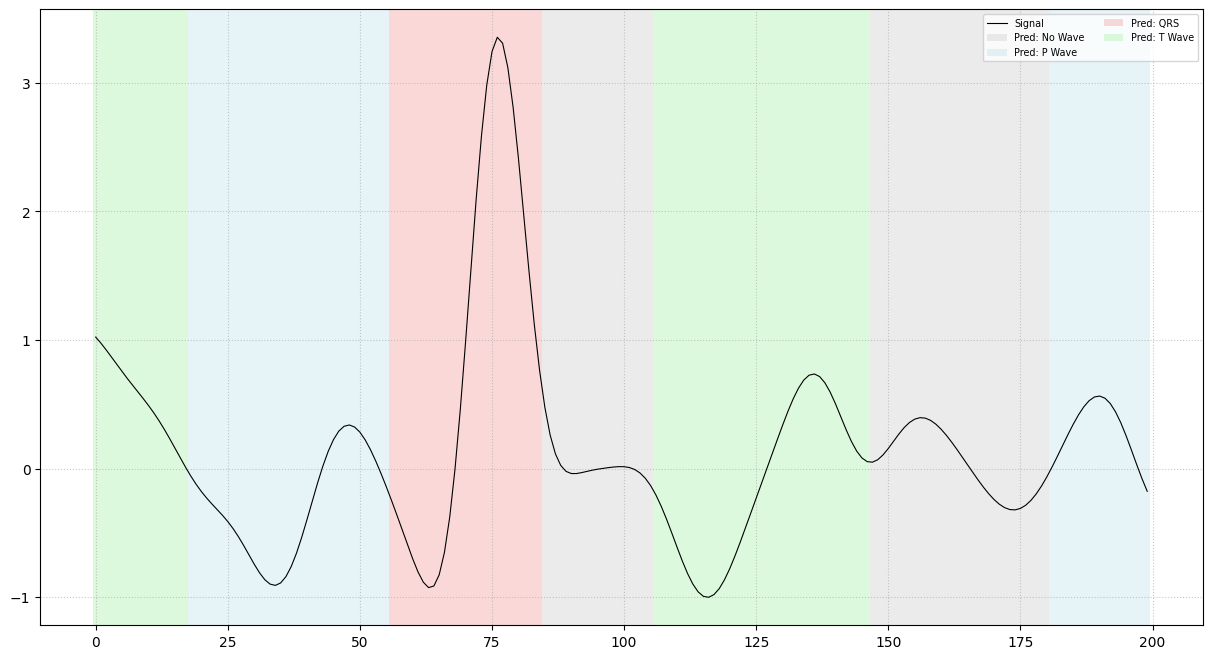

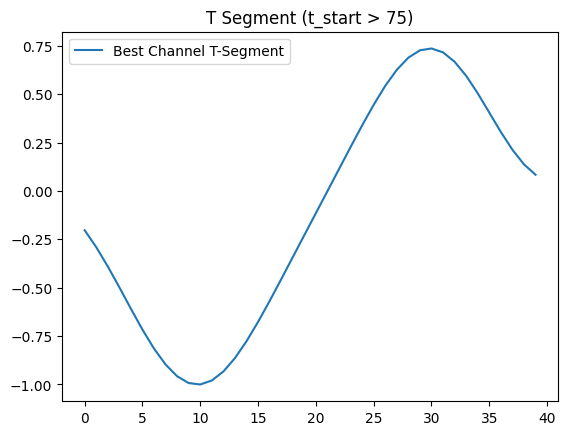

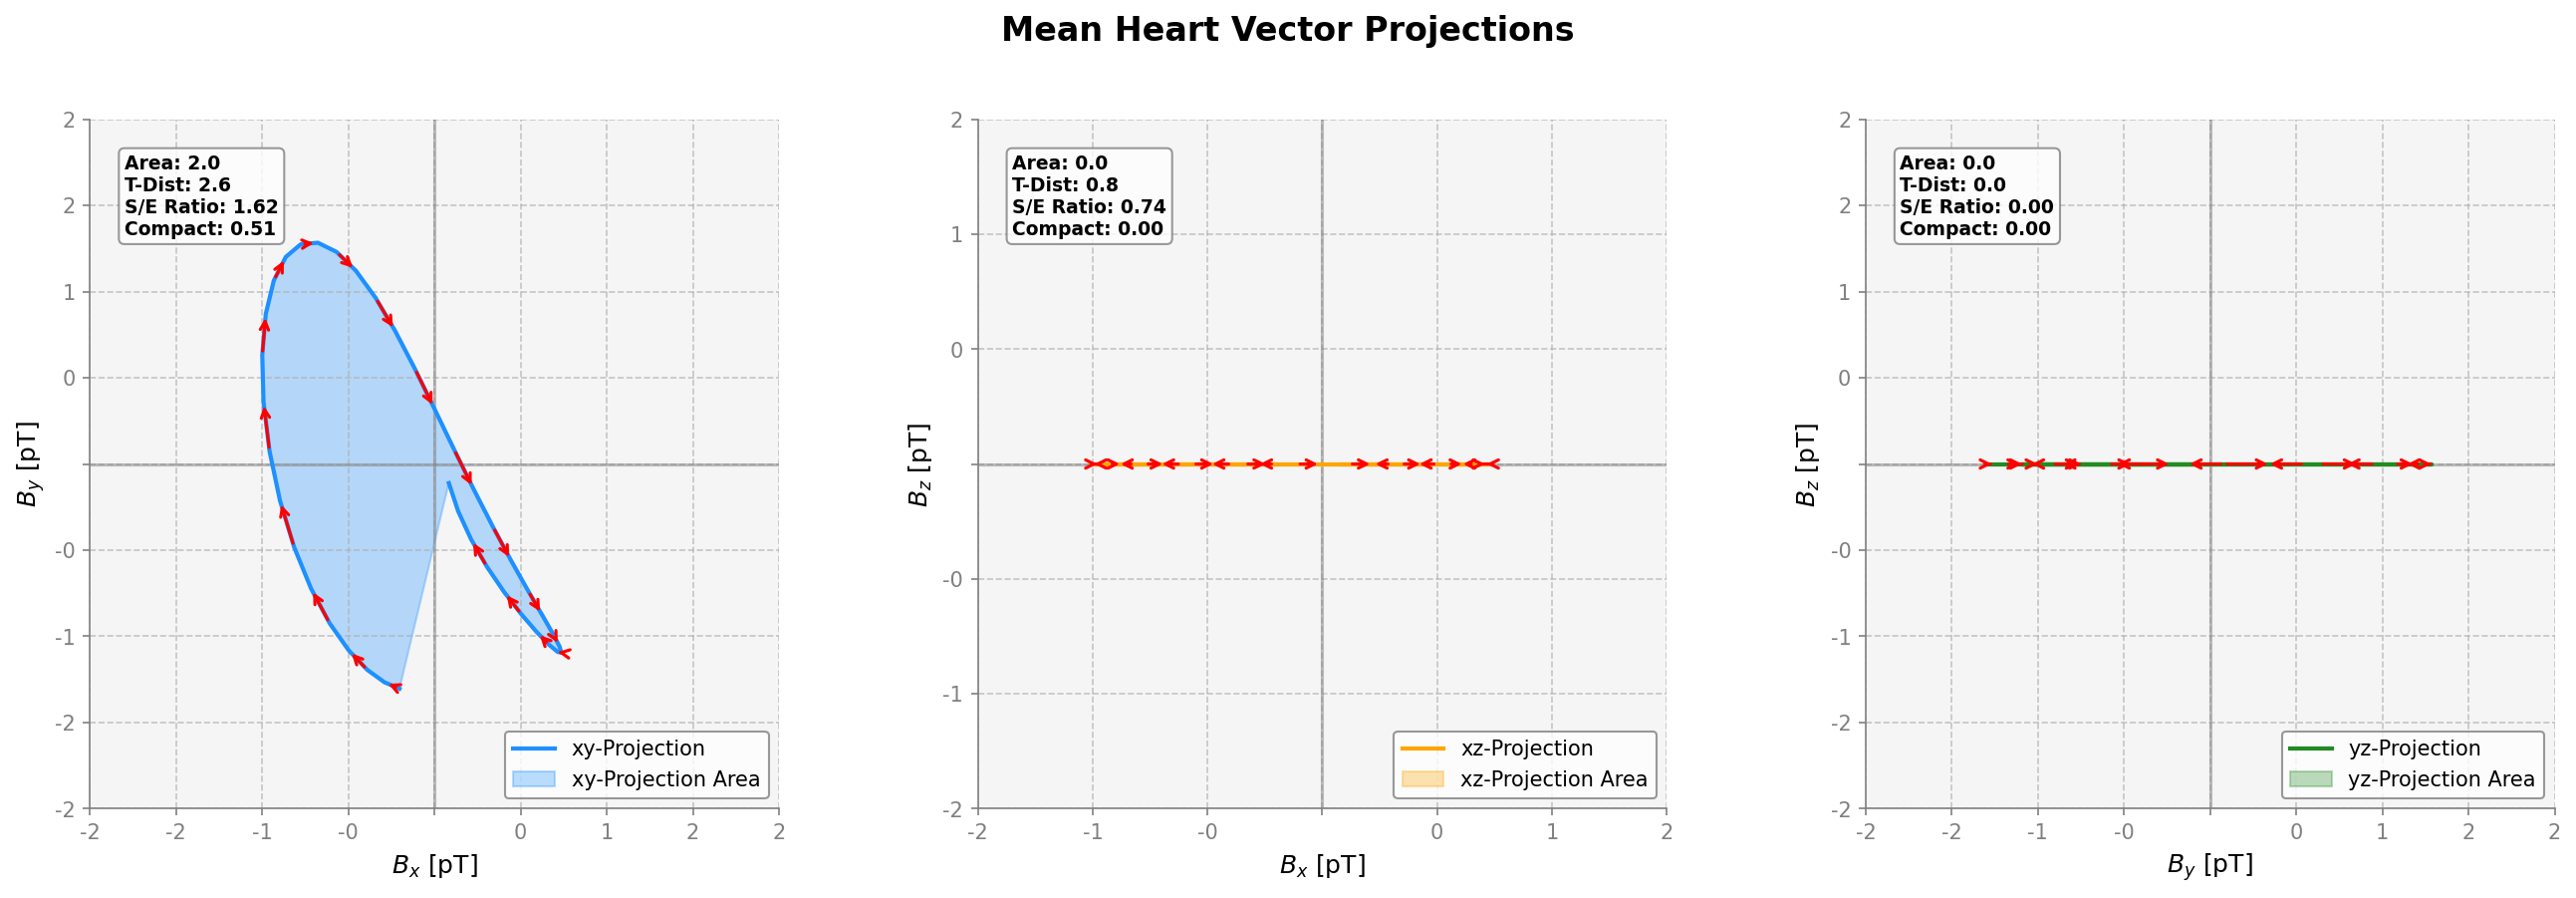

QRS start: 56, QRS end: 84, Max T index: 136


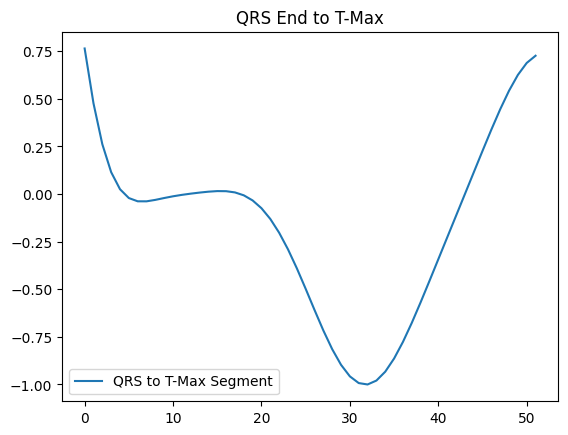

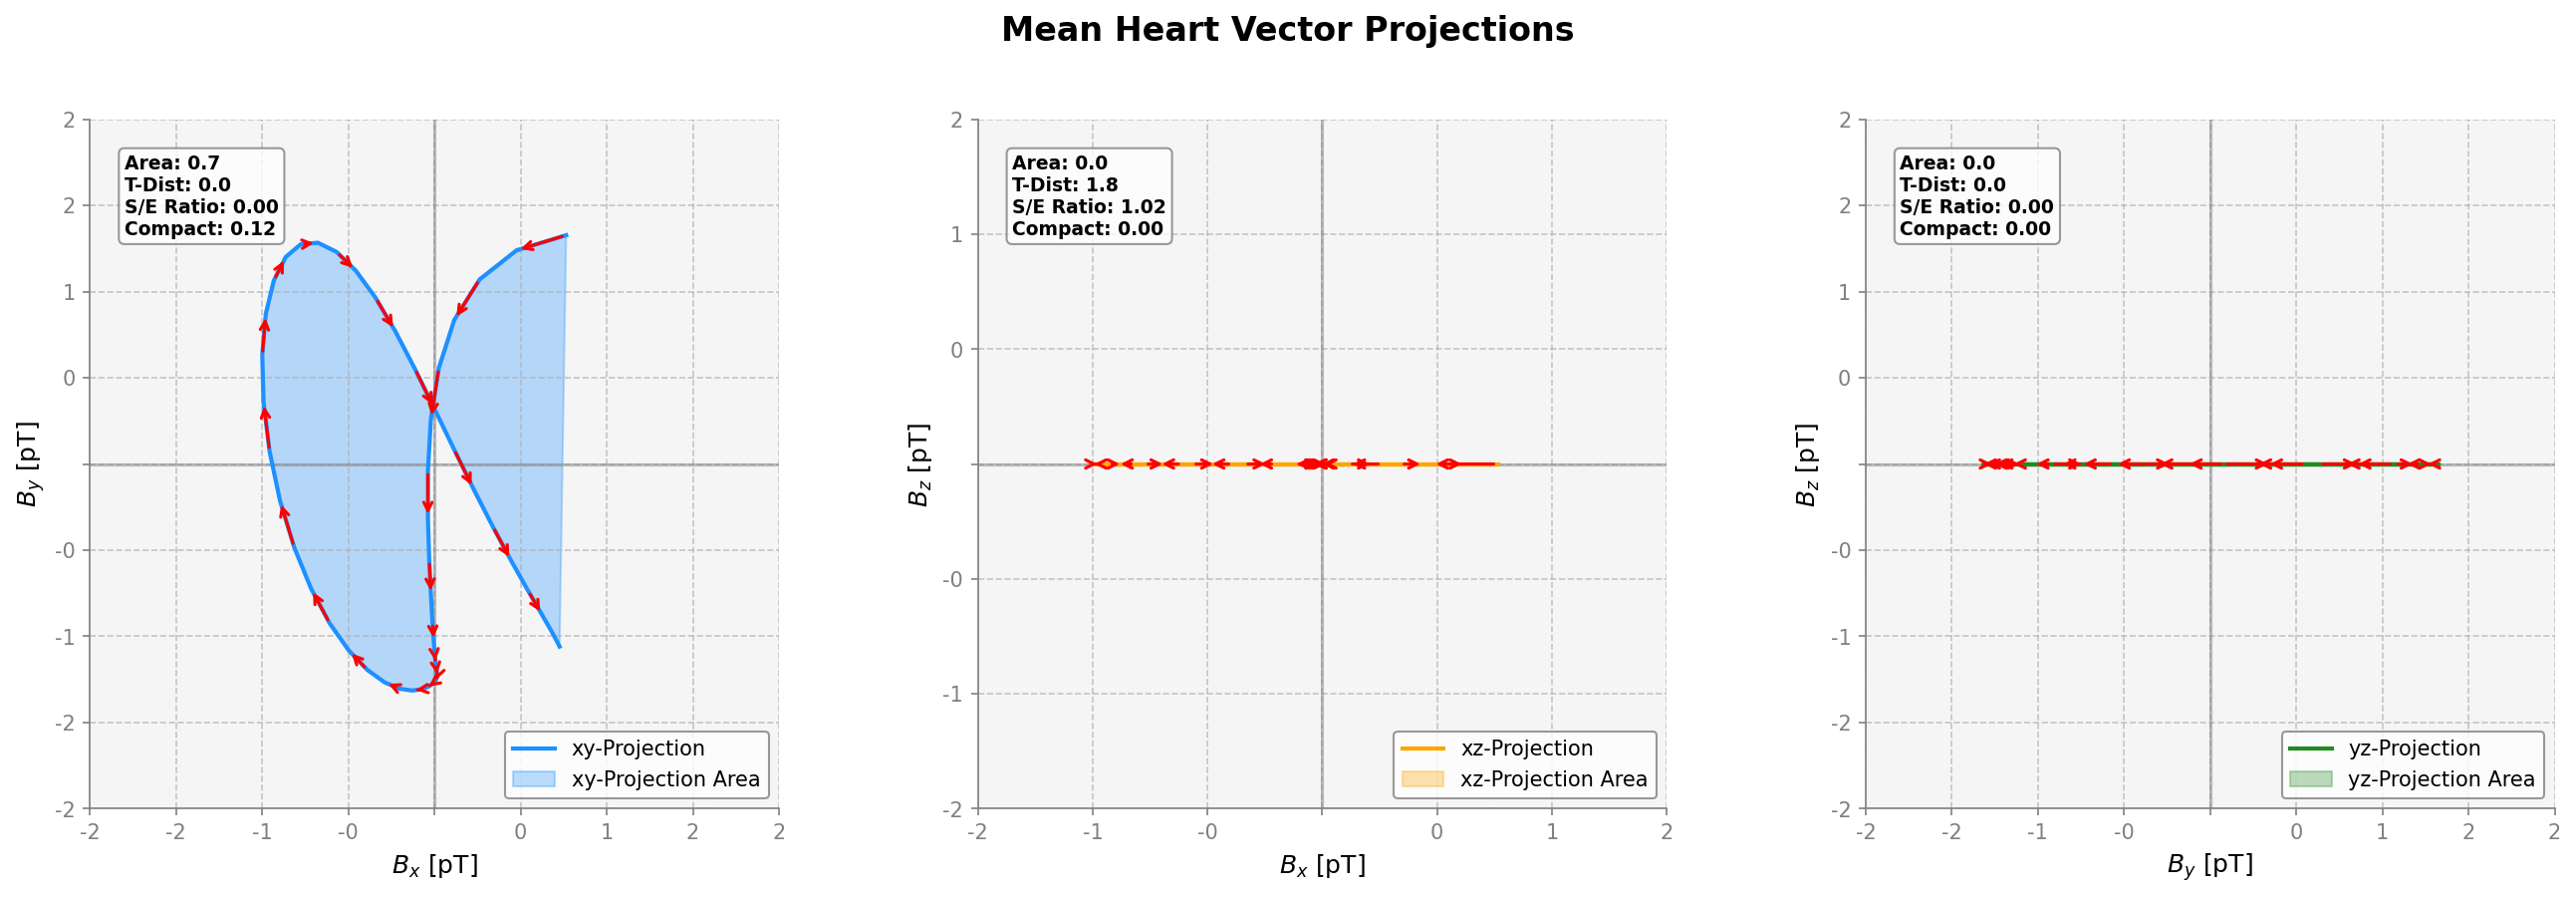

In [131]:
# Get field directions
x_data, y_data, z_data = analysis.get_field_directions(avg_channels, key)

f1_data = np.array([x_data[2, 3, :], y_data[2, 3, :], z_data[2, 3, :]])
print(f"f1_data shape: {f1_data.shape}")

# Find cleanest channel
best_channel, (labels, data, confidence) = analysis.find_cleanest_channel(
    f1_data, resample=False, confidence_weight=0.4, plausibility_weight=0.6
)

analysis.plot_segmented_signal(f1_data[best_channel], labels[best_channel])

# ----------------------------
# Get T-wave segment
# ----------------------------
mask_t = labels[best_channel] == 3
mask_t[:75] = False  # Ignore everything before index 75!

if np.any(mask_t):
    t_indices = np.where(mask_t)[0]
    t_start = t_indices[0]
    t_end = t_indices[-1]


    t_segment = f1_data[:, t_start:t_end]

    plt.figure()
    plt.plot(t_segment[best_channel], label="Best Channel T-Segment")
    plt.legend()
    plt.title("T Segment (t_start > 75)")
    plt.show()

    analysis.plot_all_heart_vector_projections(t_segment)

else:
    print("No T-wave segment found!")
    t_segment = None
# ----------------------------
# Segment from end of QRS to max of T
# ----------------------------
mask_qrs = labels[best_channel] == 2

if np.any(mask_qrs):
    t_start_qrs = np.where(mask_qrs)[0][0]
    t_end_qrs = np.where(mask_qrs)[0][-1]

    # Define search window after QRS
    search_start = t_end_qrs + 5

    search_segment = f1_data[best_channel, search_start:t_end]

    if len(search_segment) > 0:
        # Find max deviation from mean
        relative_max_idx = np.argmax(search_segment - np.mean(search_segment))
        max_t = search_start + relative_max_idx

        print(f"QRS start: {t_start_qrs}, QRS end: {t_end_qrs}, Max T index: {max_t}")

        # Slice from QRS end to T max
        segment_qrs_to_tmax = f1_data[:, t_end_qrs:max_t]

        plt.figure()
        plt.plot(segment_qrs_to_tmax[best_channel], label="QRS to T-Max Segment")
        plt.legend()
        plt.title("QRS End to T-Max")
        plt.show()

        analysis.plot_all_heart_vector_projections(segment_qrs_to_tmax)
    else:
        print("No samples available after QRS for search.")
else:
    print("No QRS segment found!")
